In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

Text(0.5, 0, 'x')

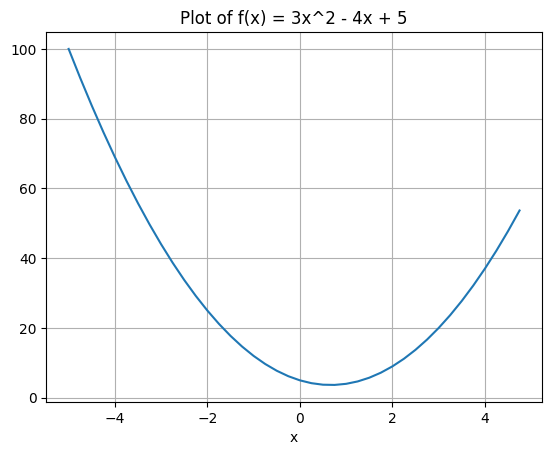

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.grid()
plt.title("Plot of f(x) = 3x^2 - 4x + 5")
plt.xlabel("x")

In [5]:
h = 0.0000001
x = 2/3
dx = (f(x+h) - f(x))/h
dx

2.9753977059954195e-07

In [6]:
# Complex one
a= 2.0
b= -3.0
c = 10.0
d1 = a*b+c
c+=h
d2 = a*b+c
ddc = (d2 - d1)/h
print("d1:", d1)
print("d2:", d2)
print("Slope of c:", ddc)

d1: 4.0
d2: 4.000000099999999
Slope of c: 0.999999993922529


In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.grad = 0.0
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other


    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data**(other -1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    

    def tanh(self):
        x = self.data
        n = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(n, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - n**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            

a = Value(2.0, label='a')
b = Value(-6.0, label='b')
c = Value(5.0, label='c') 
e = a * b

e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-4.0, label='f')
L = d * f; L.label = 'L'

test = a.__add__(b)
test 

Value(data=-4.0, label=)

In [72]:
Value(2)*1

Value(data=2, label=)

In [62]:
print(d.prev)
print(d._op)
print(d.label)

{Value(data=-12.0, label=e), Value(data=5.0, label=c)}
+
d


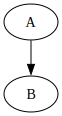

In [63]:
# Working with graphviz directly
from graphviz import Digraph

dot = Digraph()
dot.node('A')
dot.node('B')
dot.edge('A', 'B')
dot


In [64]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='png', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label , n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot


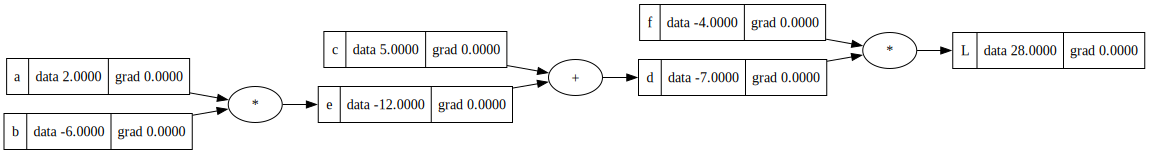

In [65]:
draw_dot(L)

In [12]:
L.grad = 1.0

L = d * f
dL/dd = f.data = -4.0

f(x+h)-f(x)/h

(d+h)*f - d*f / h
(h*f)/h = f


In [13]:
f.grad = d.data
d.grad = f.data


## Want dl/dc

d = c + e

dd/dc = 1.0

dl/dd = d.grad  

dl/dc = dl/dd * dd/dc

In [14]:
c.grad = d.grad
e.grad = d.grad

## want dl/da and dl/db
dl/da = dl/de * de/da

de/da = b

dl/db = dl/de * de/db

de/db = a

In [15]:
a.grad =b.data * e.grad
b.grad =a.data * e.grad


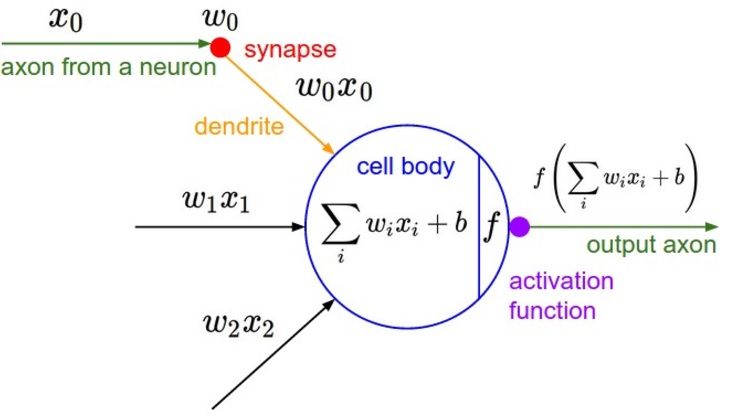

In [66]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
# Neuron output
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
n = x1w1 + x2w2; n.label='n'
o = n + b; o.label='o'

f = o.tanh(); f.label='f'


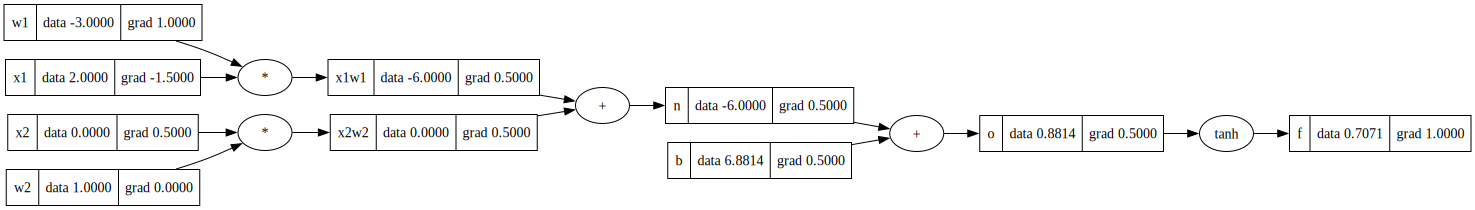

In [69]:
draw_dot(f)

In [68]:
f.backward()

In [48]:
f.grad = 1.0
f._backward()
o._backward()
b._backward()
n._backward()
x2w2._backward()
x1w1._backward()


In [ ]:
# f = tanh(o)
# df/do = 1 - tanh^2(o) = 1 - f^2
# 1-(f.data)**2
# o.grad = 0.5

## Using pytorch

In [1]:
import torch
print(torch.__version__)

2.10.0+cpu


In [5]:

x1 = torch.tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True  
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad = True
o = x1*w1 + x2*w2 + b
f = torch.tanh(o)
f.backward()


print("PyTorch gradients:")
print(f"x1.grad = {x1.grad}")
print(f"x2.grad = {x2.grad}")
print(f"w1.grad = {w1.grad}")
print(f"w2.grad = {w2.grad}")


PyTorch gradients:
x1.grad = tensor([-1.5000], dtype=torch.float64)
x2.grad = tensor([0.5000], dtype=torch.float64)
w1.grad = tensor([1.0000], dtype=torch.float64)
w2.grad = tensor([0.], dtype=torch.float64)
